In [1]:
from numpy.linalg import norm
from sklearn.metrics.pairwise import cosine_similarity
import threading
import cv2
import os
import pandas as pd
import time 
import numpy as np
from align_faces import warp_and_crop_face, get_reference_facial_points
from mtcnn.detector import MtcnnDetector

# importing the modules
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
detector = MtcnnDetector()


In [2]:
import torch
print(torch.__version__)
torch.cuda.is_available ()

1.12.1


True

In [3]:
data_csv = pd.read_csv("../train/label.csv")

In [ ]:
data_csv.head()


In [ ]:
print(data_csv["fname"])

In [5]:
len_of_lst = 160
shape_lst_image = (len_of_lst, 224, 224,3)
shape_image = (224, 224,3)

range = shape_image[0] *shape_image[1]*shape_image[2]
print(shape_lst_image)

(160, 224, 224, 3)


In [12]:
def mask_detect(image):
    (h,w) = image.shape[:2]
    boxes, facial5points = detector.detect_faces(image)
    face = np.zeros(shape =shape_image)
    if(len(boxes)!=0):
        for box in boxes:
            (startX,startY,endX,endY)=box[:4].astype('int')
            #ensure the bounding boxes fall within the dimensions of the frame
            (startX,startY)=(max(0,startX),max(0,startY))
            (endX,endY)=(min(w-1,endX), min(h-1,endY))
            #extract the face ROI, convert it from BGR to RGB channel, resize it to 224,224 and preprocess it
            c=cv2.resize(image[startY:endY, startX:endX],(shape_image[0],shape_image[1]))
            face = c
            color = (255,0,0)
            cv2.rectangle(image,(startX,startY),(endX,endY),color,2)
    return image, face

In [10]:

def get_sim_matrix(lst_img):
    lst_reshape = lst_img.reshape(len_of_lst,range)
    list_sim = cosine_similarity(lst_reshape, lst_reshape)
    return list_sim

In [13]:
def PlayCamera(id):    
    num_of_face = 0
    video_capture = cv2.VideoCapture(id)
    face = None
    width  = int(video_capture.get(3))
    height = int(video_capture.get(4))
    if height > width:
        scale = height / width
    else:
        scale = width / height
    while height>1080 or width>1080: 
        height = int(height/scale)
        width = int(width/scale)

    list_face = np.zeros(shape = shape_lst_image, dtype=np.uint8)
    while True:
        ret, frame = video_capture.read()
        
        frame = cv2.resize(frame,(width,height))
        img, face = mask_detect(frame)
        list_face[num_of_face] = face
        num_of_face +=1      
        cv2.imshow("img",frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            video_capture.release()
            cv2.destroyAllWindows()
            break
            
    video_capture.release()
    cv2.destroyAllWindows()
    return list_face

In [39]:
name_dataset = "../train/videos/"


In [8]:
def get_embeded(data_csv):
    lst_out= []
    for name in data_csv["fname"]:
        scr = name_dataset + name
        x = PlayCamera(scr)
        sim_embed = get_sim_matrix(x)
        lst_out.append(sim_embed)
    data_csv["embed"] = lst_out
    return data_csv,lst_out

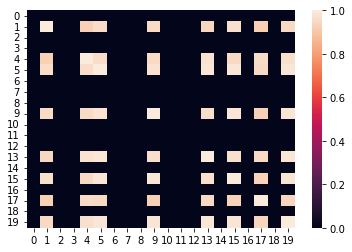

In [43]:
id = "../train/videos/7.mp4"
lsst2 = PlayCamera(id)
cv2.destroyAllWindows()
out = get_sim_matrix(lsst2)
hm = sn.heatmap(data = out[:20,:20])
plt.show()

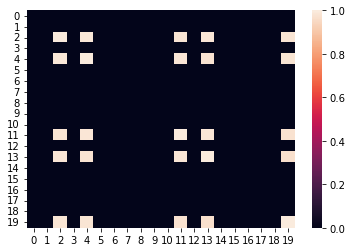

In [31]:
hm = sn.heatmap(data = out[:20,:20])
plt.show()

In [17]:
print(lsst2.sum())

493691673


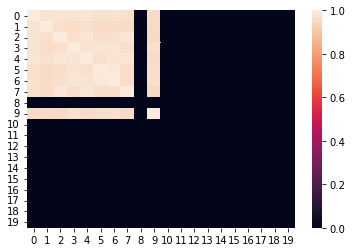

In [35]:
id = "../train_avi/videos/3.mp4"
lsst1 = PlayCamera(id)
cv2.destroyAllWindows()
out2 = get_sim_matrix(lsst1)
hm = sn.heatmap(data = out2[:20,:20])
plt.show()

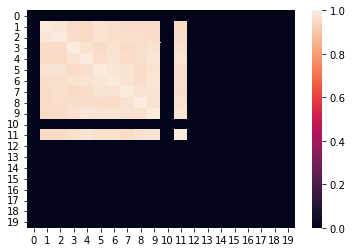

In [30]:
hm = sn.heatmap(data = out2[:20,:20])
plt.show()

In [41]:
cv2.destroyAllWindows()

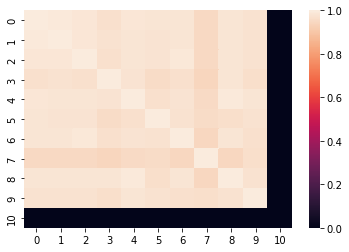

In [24]:
# rnet
hm = sn.heatmap(data = out2[:20,:20])
plt.show()

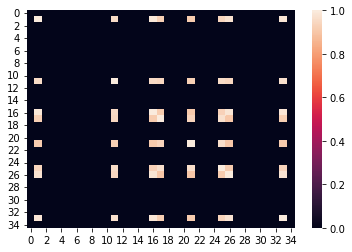

In [25]:
hm = sn.heatmap(data = out[:35,:35])
plt.show()

In [ ]:
lst_out = []
lst_out.append({
    "name":"test",
    "embed": out
})
data = pd.DataFrame(lst_out)

In [ ]:
x = data["embed"].values[0]
print(type(x))

In [ ]:
cv2.imshow("img",lsst[1])
cv2.waitKey(0) 
cv2.destroyAllWindows()

In [ ]:
cv2.destroyAllWindows()

In [ ]:
# video_capture.release()

In [ ]:
# id = "../train/videos/1.mp4"
# video_capture = cv2.VideoCapture(id)
# num = 0
# while True:
    
#     ret, frame = video_capture.read()
#     num += 1
#     img, face = mask_detect(frame)

#     cv2.imshow('{}'.format(id), img)        
#     if cv2.waitKey(1) & 0xFF == ord('q'):
        

#         break
    
# print(num)
# PlayCamera()

In [ ]:
#Convert to AVI
# import imageio
# src_dir = "../train/videos/"
# dest_dir = "../train_avi/videos/"
# lstmp4 = os.listdir(src_dir)

# for file in lstmp4:
#     scr = src_dir+file
    
#     des = dest_dir + file
    
#     reader = imageio.get_reader(scr)
#     fps = reader.get_meta_data()['fps']
#     writer = imageio.get_writer(des, fps=fps)

#     for im in reader:
#         writer.append_data(im[:, :, :])
#     writer.close()

In [ ]:
img1 = cv2.imread("Truyen_small.png")
img2 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(img1,100,200)
img_zero = np.zeros(shape =(img1.shape[0],img1.shape[1],3))
x = cosine_similarity(np.array([lsst[1].reshape(-1)]), np.array([lsst[59].reshape(-1)]))


In [ ]:
print(x)

In [ ]:
print(lst[0][0,1])
print(lsst[0,0,1])

In [ ]:
print(img1.shape)

In [ ]:
cv2.imshow("x",edges)
cv2.waitKey(0)
cv2.destroyAllWindows()